# Case Study: Zeeguu/API
- Backend of a web application that supports [free reading in foreign languages](https://zeeguu.org)
- Open source [repository on GH](https://github.com/zeeguu/API/)

# Everything that we did in Data Gathering & Abstraction


In [1]:
# Installing Required Dependencies
import sys
sys.version
#!{sys.executable} -m pip install gitpython
#!{sys.executable} -m pip install pyvis

'3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:22:19) [Clang 14.0.6 ]'

In [2]:
# In Collab our notebook runs in a temporary mounted file system
# Let's print the name of the folder where our script runs

import os
cwd = os.getcwd()
print(cwd)

/Users/davidmsoerensen/Desktop/Individual


In [3]:
# Let's declare a var for the path where we're going to download a repository
# Warning: this must end in /
CODE_ROOT_FOLDER=cwd+"/content/zeeguu-api/"
print(CODE_ROOT_FOLDER)

/Users/davidmsoerensen/Desktop/Individual/content/zeeguu-api/


In [4]:
from git import Repo
# GitPython is a library that allows us to work easily with git from Python
# https://gitpython.readthedocs.io/en/stable/tutorial.html


# If the file exists, it means we've already downloaded
if not os.path.exists(CODE_ROOT_FOLDER):
  Repo.clone_from("https://github.com/zeeguu/api", CODE_ROOT_FOLDER)
else:
  print("Seems that the repo already exists :)")

Seems that the repo already exists :)


In [5]:
# helper function to get a file path w/o having to always provide the /content/zeeguu-api/ prefix
def file_path(file_name):
    return CODE_ROOT_FOLDER+file_name

assert (file_path("zeeguu/core/model/user.py") == cwd+"/content/zeeguu-api/zeeguu/core/model/user.py")


In [6]:
# extracting a module name from a file name
def module_name_from_file_path(full_path):

    # e.g. ../core/model/user.py -> zeeguu.core.model.user

    file_name = full_path[len(CODE_ROOT_FOLDER):]
    file_name = file_name.replace("/__init__.py","")
    file_name = file_name.replace("/",".")
    file_name = file_name.replace(".py","")
    return file_name

assert 'zeeguu.core.model.user' == module_name_from_file_path(file_path('zeeguu/core/model/user.py'))

In [7]:
# naïve way of extracting imports using regular expressions
import re


# we assume that imports are always at the
# TODO for you: add full support for imports; this is not complete...
def import_from_line(line):

    # regex patterns used
    #   ^  - beginning of line
    #   \S - anything that is not space
    #   +  - at least one occurrence of previous
    #  ( ) - capture group (read more at: https://pynative.com/python-regex-capturing-groups/)
    try:
      y = re.search(r"^from (\S+)", line)
      if not y:
        y = re.search(r"^import (\S+)", line)
      return y.group(1)
    except:
      return None


# extracts all the imported modules from a file
# returns a module of the form zeeguu_core.model.bookmark, e.g.
def imports_from_file(file):

    all_imports = []

    lines = [line for line in open(file)]

    for line in lines:
        imp = import_from_line(line)

        if imp:
            all_imports.append(imp)

    return all_imports

imports_from_file(file_path('zeeguu/core/model/user.py'))

['datetime',
 'json',
 'random',
 're',
 'sqlalchemy.orm',
 'zeeguu.core',
 'sqlalchemy',
 'sqlalchemy.orm',
 'sqlalchemy.orm.exc',
 'zeeguu.core.language.difficulty_estimator_factory',
 'zeeguu.core.model.language',
 'zeeguu.core.model.learning_cycle',
 'zeeguu.logging',
 'zeeguu.core.util',
 'zeeguu.core.model',
 'zeeguu.logging']

In [8]:
# test
print(imports_from_file(file_path('zeeguu/core/model/bookmark.py')))
print(imports_from_file(file_path('zeeguu/core/model/unique_code.py')))

['datetime', 'sqlalchemy', 'sqlalchemy', 'sqlalchemy.orm', 'sqlalchemy.orm.exc', 'zeeguu.core.model.caption', 'zeeguu.core.model.video', 'zeeguu.logging', 'zeeguu.core.bookmark_quality.fit_for_study', 'zeeguu.core.model.article', 'zeeguu.core.model.exercise', 'zeeguu.core.model.exercise_outcome', 'zeeguu.core.model.exercise_source', 'zeeguu.core.model.language', 'zeeguu.core.model.source', 'zeeguu.core.model.text', 'zeeguu.core.model.user', 'zeeguu.core.model.user_word', 'zeeguu.core.model.learning_cycle', 'zeeguu.core.model.bookmark_user_preference', 'zeeguu.core.model.bookmark_context', 'zeeguu.core.model', 'zeeguu.core.util.encoding', 'wordstats']
['datetime', 'random', 'zeeguu.core', 'sqlalchemy', 'zeeguu.core.model']


## Now we extract the dependencies between all the files

To do that we iterate over all the python files with the hel pf the `Path.rglob` function from `pathlib`

And we create a network with the help of the `networkx` package.

In [9]:
import pathlib
from pathlib import Path
import networkx as nx

def dependencies_graph(code_root_folder):
    files = Path(code_root_folder).rglob("*.py")

    G = nx.Graph()

    for file in files:
        file_path = str(file)

        module_name = module_name_from_file_path(file_path)

        if module_name not in G.nodes:
            G.add_node(module_name)

        for each in imports_from_file(file_path):
            G.add_edge(module_name, each)

    return G

## Mathplotlib also has support for drawing networks

We do a simple drawing of all the files and their dependencies in our system

In [10]:
import matplotlib.pyplot as plt

# a function to draw a graph
def draw_graph(G, size, **args):
    plt.figure(figsize=size)
    nx.draw(G, **args)
    plt.show()

In [11]:
G = dependencies_graph(CODE_ROOT_FOLDER)

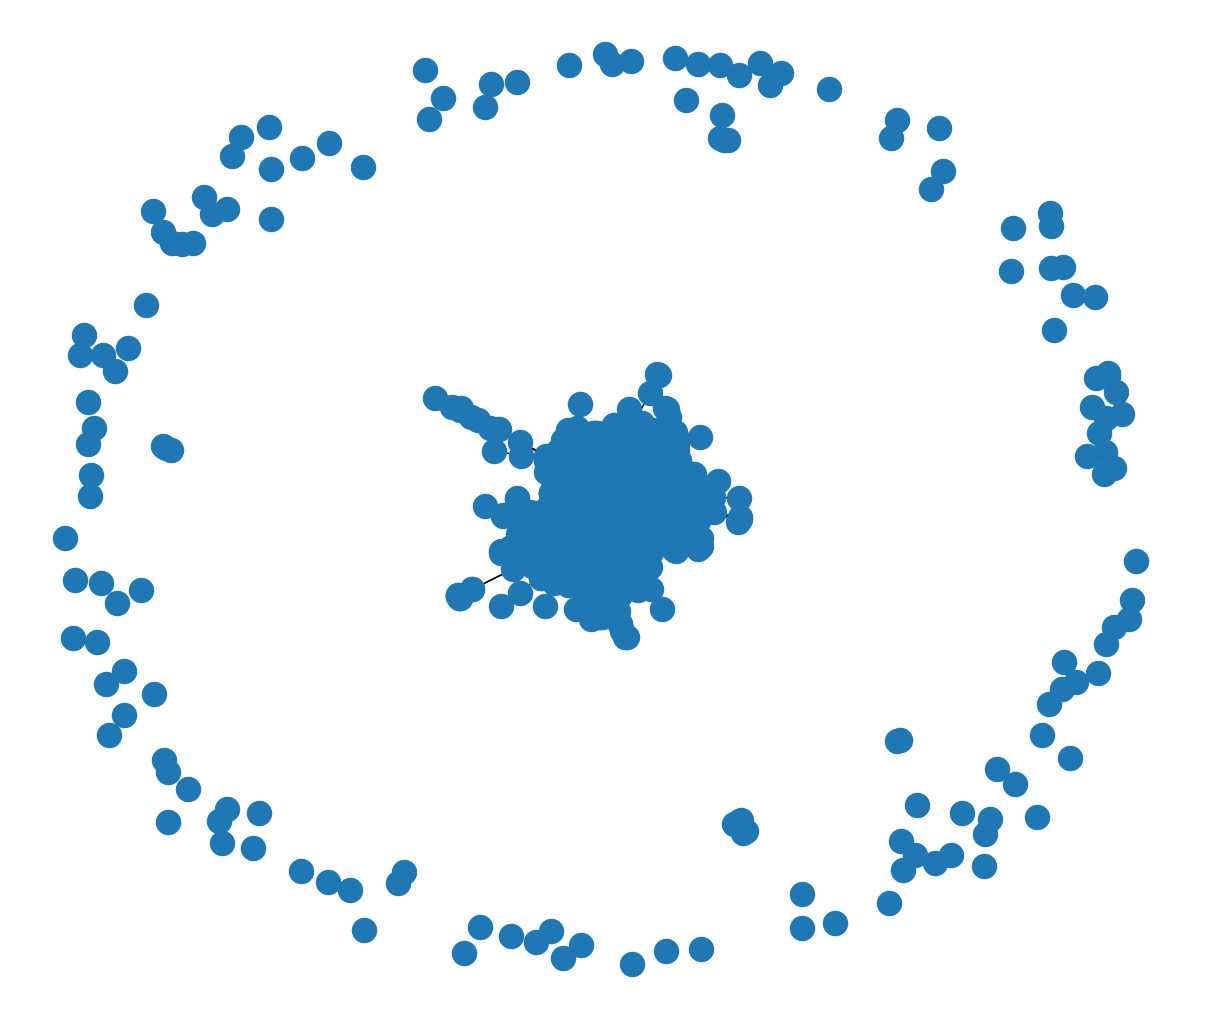

In [35]:
draw_graph(G, (12,10), with_labels=False, pos=nx.spring_layout(G))

## Abstraction

In [13]:
# Let's define some relevant modules
def relevant_module(module_name):

  if "test" in module_name:
    return False


  if module_name.startswith("zeeguu"):
    return True


  return False

In [ ]:
# However, if we think a bit more about it, we realize that a dependency graph
# is a directed graph (e.g. module A depends on m)
# with any kinds of graph either directed (nx.DiGraph) or
# non-directed (nx.Graph)

def dependencies_digraph(code_root_folder):
    files = Path(code_root_folder).rglob("*.py")

    G = nx.DiGraph()

    for file in files:
        file_path = str(file)

        source_module = module_name_from_file_path(file_path)
        if not relevant_module(source_module):
          continue

        if source_module not in G.nodes:
            G.add_node(source_module)

        for target_module in imports_from_file(file_path):

            if relevant_module(target_module):
              G.add_edge(source_module, target_module)


    return G


In [15]:
# Looking at the directed graph
DG = dependencies_digraph(CODE_ROOT_FOLDER)

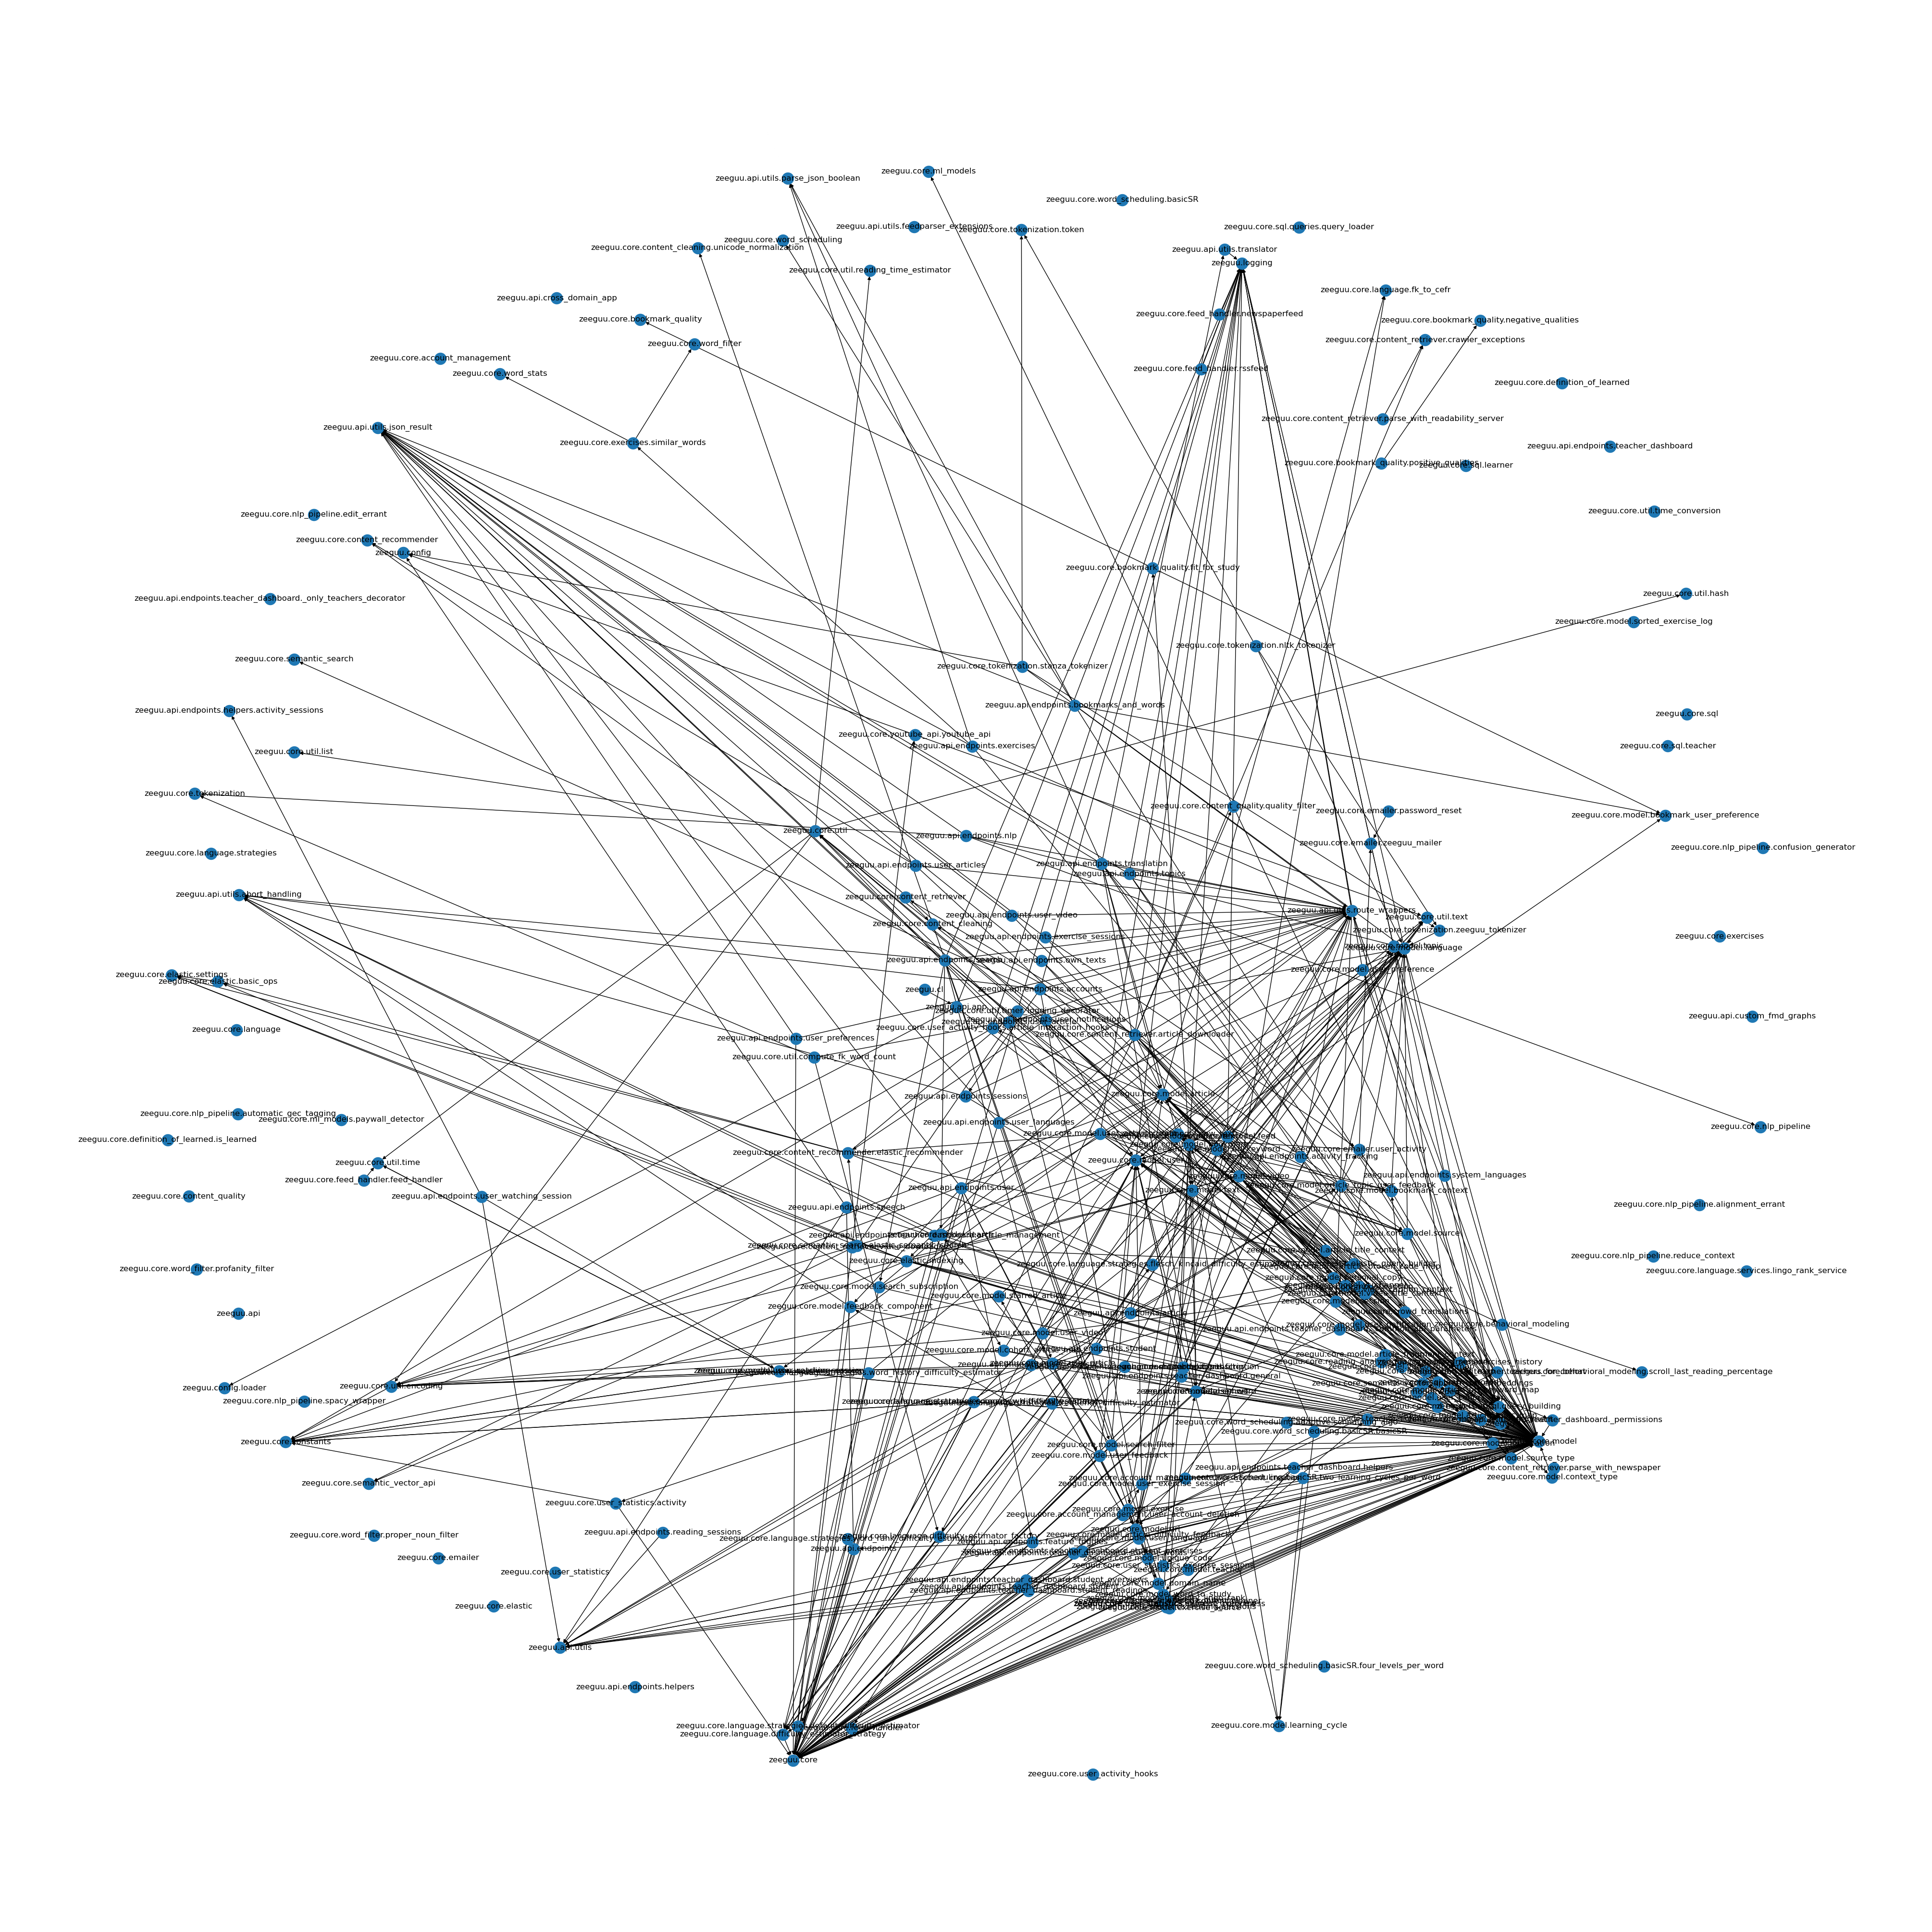

In [16]:
draw_graph(DG, (40,40), with_labels=True, pos=nx.spring_layout(DG))

## Basic Abstraction Using Hierarchical Module Structure & Naming Conventions

- abstracting the imports between the modules along the module hierarchy
- also taking into account naming conventions to filter out external modules

In [17]:
# extracts the parent of depth X
def top_level_package(module_name, depth=1):
    components = module_name.split(".")
    return ".".join(components[:depth])

assert (top_level_package("zeeguu.core.model.util") == "zeeguu")
assert (top_level_package("zeeguu.core.model.util", 2) == "zeeguu.core")

In [ ]:
def abstracted_to_top_level(G : nx.DiGraph, depth=1):
    aG = nx.DiGraph()
    for each in G.edges():
        src = top_level_package(each[0], depth)
        dst = top_level_package(each[1], depth)

        if src != dst:
          if (src, dst) in aG.edges():
            w = aG[src][dst]['weight'] # Credit to Claude.AI
            aG.add_edge(src, dst, weight=w+1)
          else:
             aG.add_edge(src, dst, weight=1)

    return aG

In [104]:
ADG = abstracted_to_top_level(DG, 2)

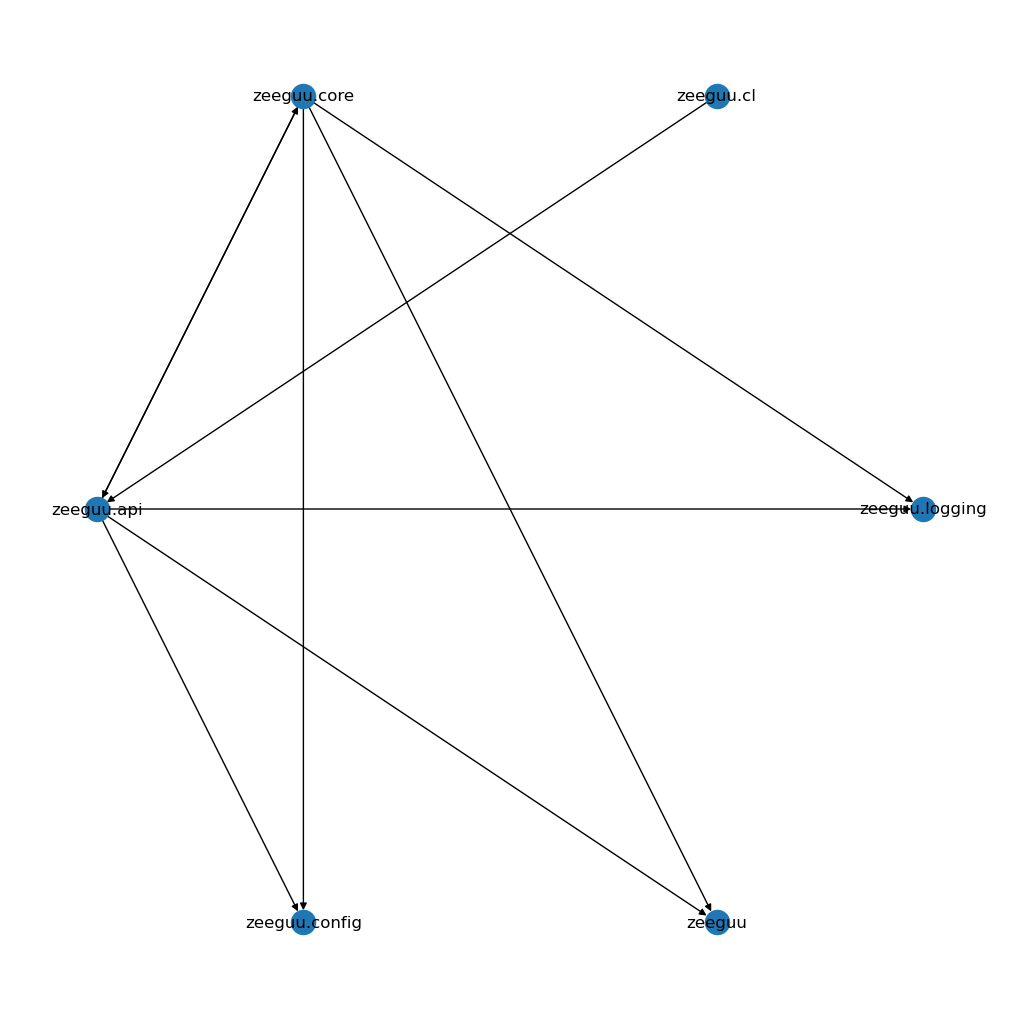

In [105]:
plt.figure(figsize=(10,10))
nx.draw(ADG, with_labels=True, pos=nx.shell_layout(ADG))
plt.show()

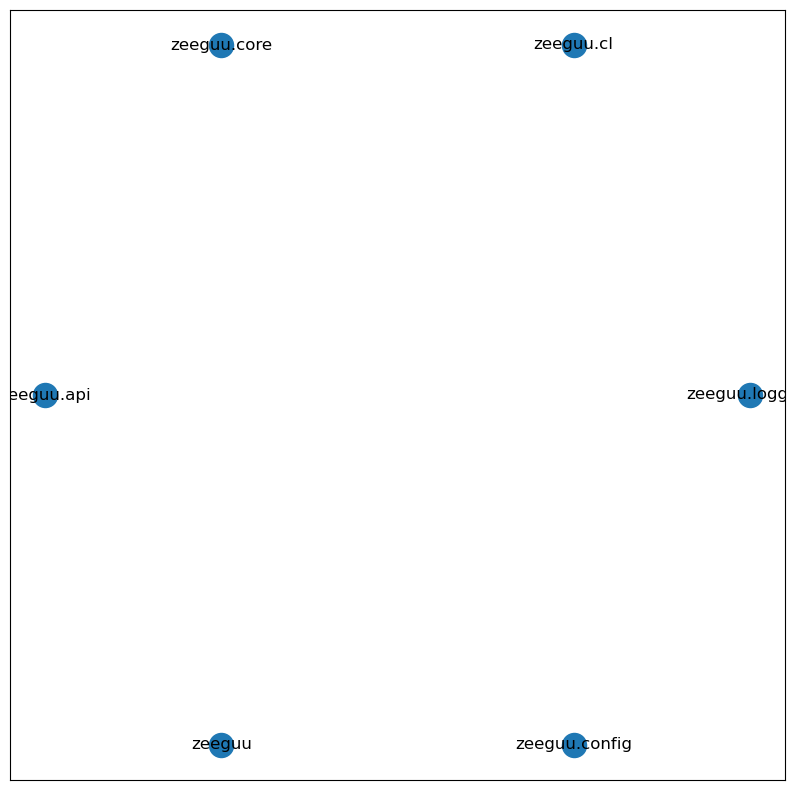

In [101]:
# Inspiration = https://stackoverflow.com/a/70245742
pos = nx.shell_layout(ADG)
fig = plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(ADG, pos)
nx.draw_networkx_labels(ADG, pos)
fig.savefig("1.png")

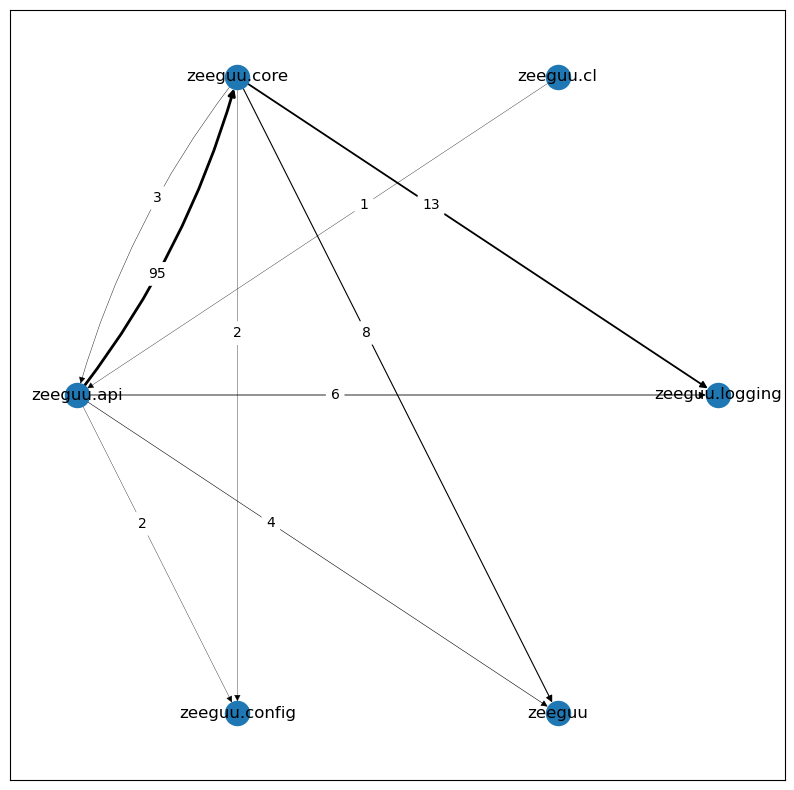

In [138]:
# Inspiration = https://stackoverflow.com/a/70245742
### Init ###
pos = nx.shell_layout(ADG)
fig = plt.figure(figsize=(10,10))

# Edges
curved_edges = [edge for edge in ADG.edges() if reversed(edge) in ADG.edges()]
straight_edges = list(set(ADG.edges()) - set(curved_edges))
arc_rad = 0.1

# Edge weights
edge_weights = nx.get_edge_attributes(ADG, 'weight')


straight_edge_widths = [max(0.25, min(2, edge_weights[edge]/10)) for edge in straight_edges]
curved_edge_widths = [max(0.25, min(2, edge_weights[edge]/10)) for edge in curved_edges]

curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}

### DRAW ###
# Nodes
nx.draw_networkx_nodes(ADG, pos)
nx.draw_networkx_labels(ADG, pos)

# Edges
nx.draw_networkx_edges(ADG, pos, edgelist=straight_edges, width=straight_edge_widths)
nx.draw_networkx_edges(ADG, pos, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}', width=curved_edge_widths)

# Edge labels
nx.draw_networkx_edge_labels(ADG, pos, edge_labels=curved_edge_labels, 
                             rotate=False, connectionstyle=f'arc3, rad = {arc_rad}',
                             label_pos=0.4)
nx.draw_networkx_edge_labels(ADG, pos, edge_labels=straight_edge_labels,
                             rotate=False, label_pos=0.4)

# Draw
fig.savefig("x.png", bbox_inches='tight', pad_inches=0)

# Evolution Analysis

In [21]:
#!{sys.executable} -m pip install pydriller==2.6

In [22]:
from pydriller import Repository
REPO_DIR = 'https://github.com/zeeguu/api'

In [23]:
# for PyDriller to work we need to change directory to our local clone of the repo
%cd content/zeeguu-api

/Users/davidmsoerensen/Desktop/Individual/content/zeeguu-api


In [24]:
all_commits = list(Repository(REPO_DIR).traverse_commits())

def print_out_commit_details(commits):
  for commit in commits:
      print(commit)
      for each in commit.modified_files:
          print(f"{commit.author.name} {each.change_type} {each.filename}\n -{each.old_path}\n -{each.new_path}")

#print_out_commit_details(all_commits[0:1])

In [25]:
from collections import defaultdict

commit_counts = defaultdict(int)

for commit in all_commits:
    for each in commit.modified_files:
        try:
            commit_counts [each.new_path] += 1
        except:
            pass

# sort by number of commits in decreasing order
sorted(commit_counts.items(), key=lambda x: x[1], reverse=True)[:42]

# discussion: What is ("None", 103) ?

[(None, 211),
 ('zeeguu/core/model/article.py', 84),
 ('zeeguu_api/api/dashboard.py', 80),
 ('zeeguu_api/api/translate_and_bookmark.py', 78),
 ('zeeguu_api/api/teacher_dashboard.py', 76),
 ('zeeguu/core/content_retriever/article_downloader.py', 74),
 ('requirements.txt', 69),
 ('zeeguu/core/model/bookmark.py', 68),
 ('zeeguu/core/content_recommender/elastic_recommender.py', 55),
 ('zeeguu/core/elastic/elastic_query_builder.py', 54),
 ('README.md', 52),
 ('zeeguu_api/api/feeds.py', 51),
 ('zeeguu_api/app.py', 51),
 ('zeeguu/core/emailer/zeeguu_mailer.py', 51),
 ('zeeguu/core/model/user.py', 49),
 ('zeeguu/core/model/video.py', 47),
 ('setup.py', 46),
 ('zeeguu/core/model/__init__.py', 46),
 ('zeeguu_api/api/__init__.py', 44),
 ('zeeguu/core/elastic/indexing.py', 42),
 ('zeeguu/api/endpoints/translation.py', 40),
 ('zeeguu/core/word_scheduling/basicSR/basicSR.py', 39),
 ('Dockerfile', 37),
 ('.travis.yml', 34),
 ('zeeguu/core/model/user_activitiy_data.py', 34),
 ('docker-compose.yml', 33

In [ ]:
from pydriller import ModificationType

commit_counts = {}

for commit in all_commits:
    for modification in commit.modified_files:

        new_path = modification.new_path
        old_path = modification.old_path

        try:

            if modification.change_type == ModificationType.RENAME:
                commit_counts[new_path]=commit_counts.get(old_path,0)+1
                commit_counts.pop(old_path)

            elif modification.change_type == ModificationType.DELETE:
                commit_counts.pop(old_path, '')

            elif modification.change_type == ModificationType.ADD:
                commit_counts[new_path] = 1

            else: # modification to existing file
                    commit_counts [old_path] += 1
        except Exception as e:
            print("something went wrong with: " + str(modification))
            pass

sorted(commit_counts.items(), key=lambda x:x[1], reverse=True)

%cd ../..

something went wrong with: <pydriller.domain.commit.ModifiedFile object at 0x11fe05e80>
something went wrong with: <pydriller.domain.commit.ModifiedFile object at 0x17404f830>
something went wrong with: <pydriller.domain.commit.ModifiedFile object at 0x11fc94c80>
something went wrong with: <pydriller.domain.commit.ModifiedFile object at 0x1194595e0>


[('zeeguu/api/endpoints/translation.py', 129),
 ('zeeguu/core/model/article.py', 94),
 ('zeeguu/api/app.py', 80),
 ('zeeguu/core/model/bookmark.py', 80),
 ('zeeguu/core/content_retriever/article_downloader.py', 76),
 ('requirements.txt', 65),
 ('zeeguu/core/content_recommender/elastic_recommender.py', 57),
 ('zeeguu/core/elastic/elastic_query_builder.py', 57),
 ('zeeguu/api/endpoints/__init__.py', 57),
 ('zeeguu/api/endpoints/exercises.py', 57),
 ('zeeguu/api/endpoints/feature_toggles.py', 56),
 ('zeeguu/core/model/user.py', 54),
 ('README.md', 52),
 ('zeeguu/core/emailer/zeeguu_mailer.py', 52),
 ('zeeguu/core/model/__init__.py', 49),
 ('zeeguu/core/model/video.py', 47),
 ('setup.py', 46),
 ('zeeguu/api/endpoints/user.py', 46),
 ('zeeguu/api/endpoints/search.py', 44),
 ('zeeguu/api/endpoints/user_articles.py', 43),
 ('zeeguu/core/elastic/indexing.py', 42),
 ('zeeguu/api/endpoints/bookmarks_and_words.py', 42),
 ('zeeguu/core/word_scheduling/basicSR/basicSR.py', 39),
 ('zeeguu/api/endpoi

In [27]:


def module_name_from_rel_path(full_path):

    # e.g. ../core/model/user.py -> zeeguu.core.model.user

    file_name = full_path.replace("/__init__.py","")
    file_name = file_name.replace("/",".")
    file_name = file_name.replace(".py","")
    return file_name


assert ("tools.migrations.teacher_dashboard_migration_1.upgrade" == module_name_from_rel_path("tools/migrations/teacher_dashboard_migration_1/upgrade.py"))

assert ("zeeguu.api") == module_name_from_rel_path("zeeguu/api/__init__.py")

In [28]:
package_activity = defaultdict(int)

for path, count in commit_counts.items():
    if ".py" in str(path):
        l2_module = top_level_package(module_name_from_rel_path(path), 2)
        package_activity[l2_module] += count

sorted_sizes = sorted(package_activity.items(), key=lambda x: x[1], reverse=True)

print(sorted_sizes)



[('zeeguu.core', 2057), ('zeeguu.api', 1196), ('tools.old', 175), ('setup', 46), ('tools.update_article_content', 33), ('tools.report_generator', 33), ('tools.feed_retrieval', 21), ('tools._playground', 16), ('zeeguu.config', 15), ('tools.evaluate_infer_topics', 15), ('tools.activity_monitor', 14), ('tools.send_subscription_emails', 12), ('tools.run_knn_similarity_search', 12), ('tools.update_bookmark_pointers', 12), ('tools.transform_text_into_context', 12), ('start', 11), ('tools.delete_dev_users', 11), ('tools.update_es_based_on_url_keyword', 11), ('tools.mysql_to_elastic_for_articles', 11), ('tools.article_crawler', 10), ('tools.anonymize_users', 9), ('tools.add_feed', 7), ('env_var_defs_default', 6), ('tools.feed_info', 6), ('tools.extract_articles_with_new_topics', 6), ('tools.set_new_topics_article', 6), ('tools.tokenizer_playground', 6), ('tools.mark_broken_articles', 5), ('tools.users_recently_active', 5), ('tools.crawl_summary', 4), ('tools.get_lang_stats', 4), ('install_stan

In [29]:

sizes = []

for n in ADG.nodes():
  sizes.append(package_activity[n])

print(sizes)


[1196, 15, 2, 2, 2, 2057]


/Users/davidmsoerensen/Desktop/Individual


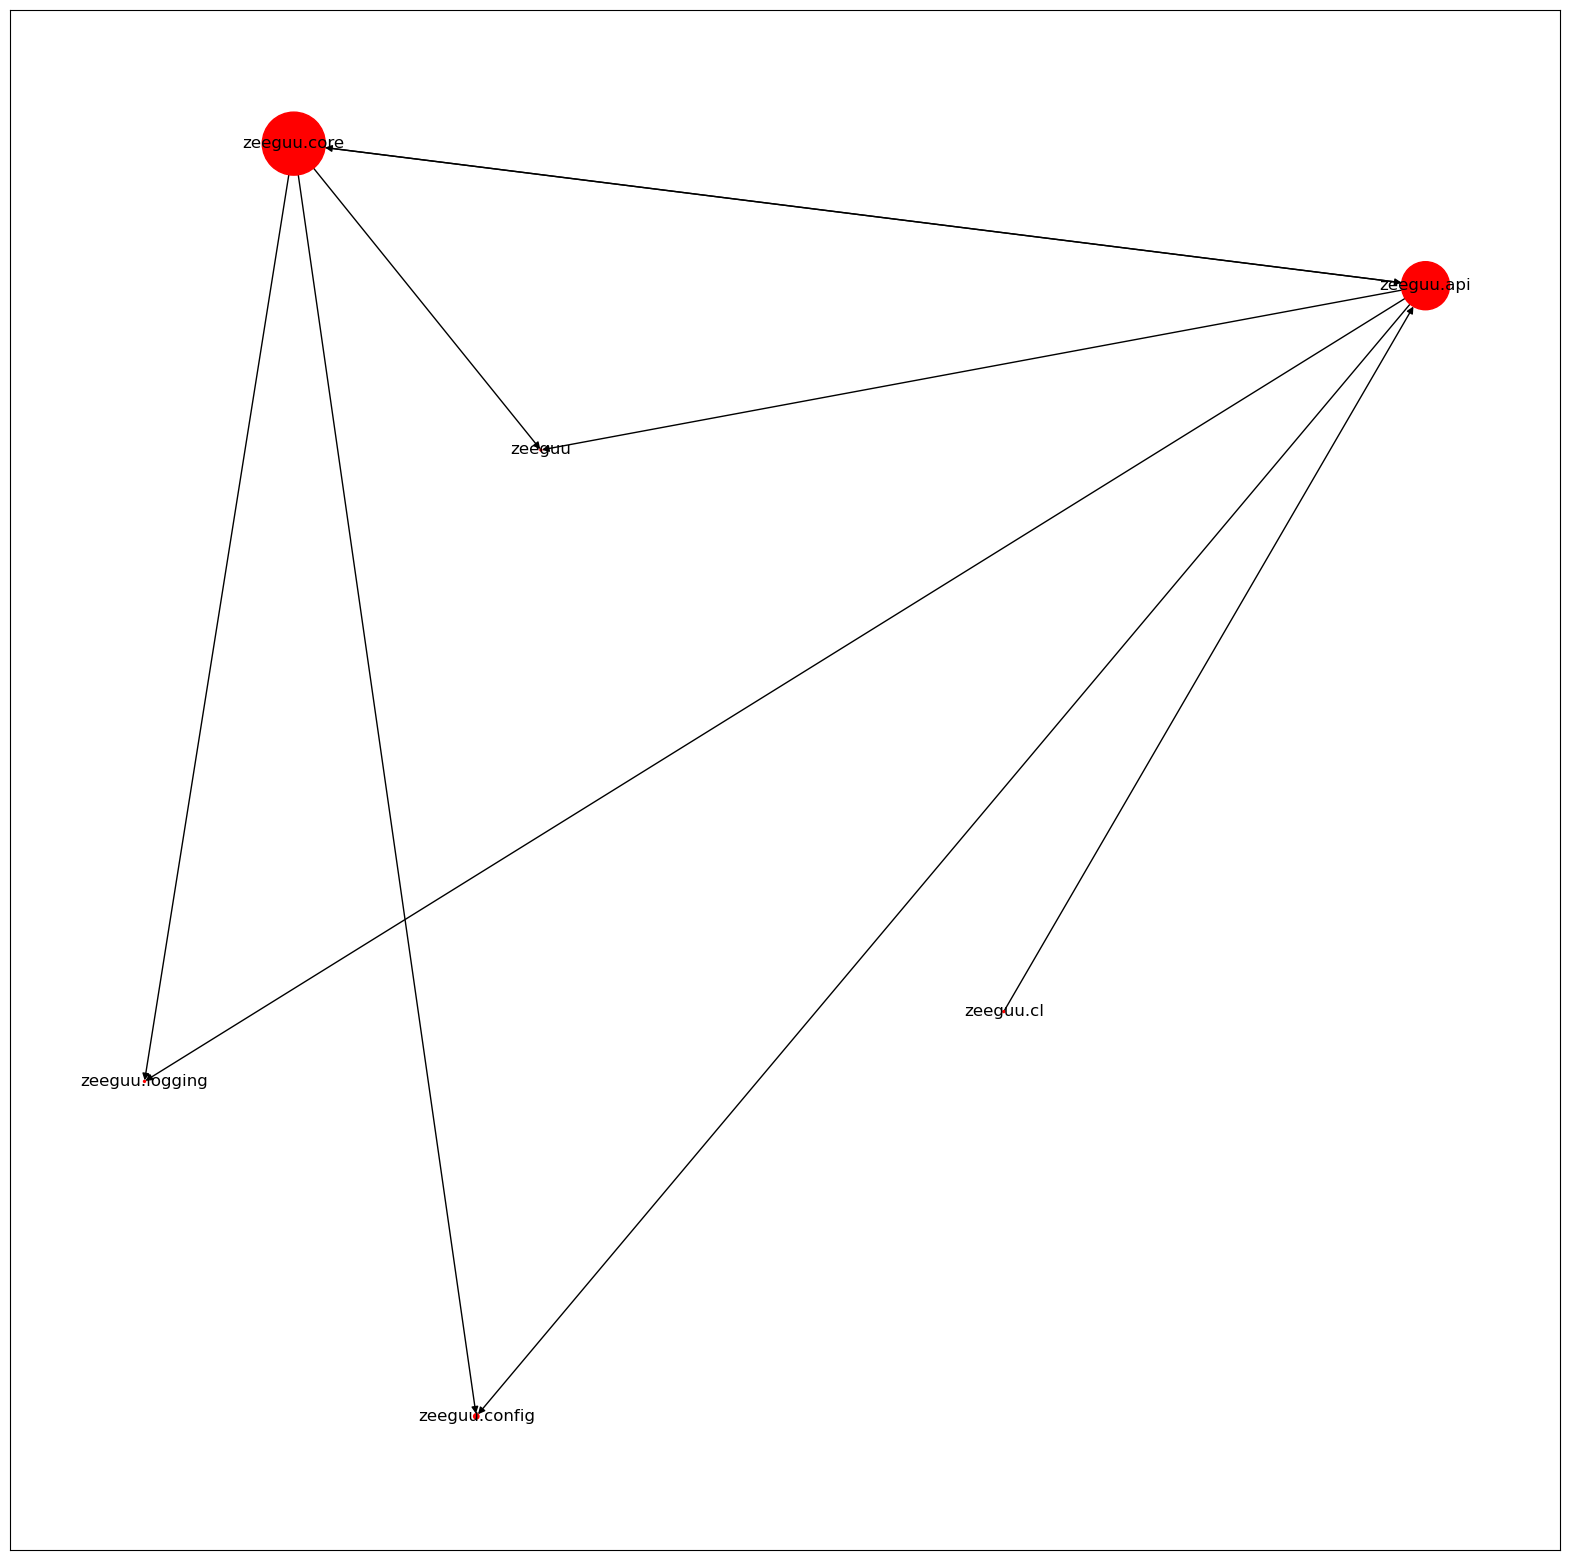

In [30]:
plt.figure(figsize=(20,20))
nx.draw_networkx(ADG, with_labels=True, node_size = sizes, node_color='r', pos=nx.kamada_kawai_layout(G))
plt.show()

# For Home: Extract Multiple Evolution Hotspots from Zeeguu

- Extract multiple complementary module views from your case study system
- Ensure that your layouts are readable - limit the number of nodes in a view, use a different layout in networkx, or use a different library than networkx
- Augment each of the previously obtained module views by mapping the above-computed churn metric on the color of a given node